In [1]:
import pymc3 as pm
import theano.tensor as tt

WARNING (theano.configdefaults): install mkl with `conda install mkl-service`: No module named mkl


In [2]:
import numpy as np

In [3]:
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
def sample_gp_posterior(F_column, n_sample=100, gprior_params=(10, 1),  prior_scale=5., sigma=1e-3, test=False):
    """
    Sample from GP posterior given one column of F (single factor).
    
    Args
        F_column: (numpy array) [t] latent observations at t time points
        n_sample: (int) MCMC chain length
        gprior_params: (tuple) Gamma prior on length scale (distance between adjacent time points is always 1)
        prior_scale: (float) half-Cauchy prior scale
        sigma: (float) Gaussian process noise (set to small number for noise free latent process)
        test: (bool) test mode returns the trace
    """
    t = F_column.shape[0]
    X = np.linspace(1, t, t).reshape((t, 1))
    with pm.Model() as model:
        l = pm.Gamma('l', gprior_params[0], gprior_params[1])  # informative prior for length scale
        s = pm.HalfCauchy('s', prior_scale)  # recommended prior for scale parameter
        K = s ** 2 * pm.gp.cov.Matern52(1, l)  # Matern (nu=2.5) kernel
        gp = pm.gp.Marginal(cov_func=K)
        y_ = gp.marginal_likelihood('y', X=X, y=F_column, noise=sigma)
        trace = pm.sample(n_sample)
    mu, cov = gp.predict(X, point=trace[-1])
    if test:
        return mu, cov, trace
    else:
        return mu, cov

In [5]:
def blr(y, F, mu_0, Sigma_0, a_0, b_0, n_draws=1):
    n = y.shape[0]
    p = mu_0.shape[0]
    mu_post = np.matmul(np.linalg.inv(np.matmul(np.transpose(F), F) + Sigma_0),
                        np.matmul(Sigma_0, mu_0) + np.matmul(np.transpose(F), y))
    Sigma_post = np.matmul(np.transpose(F), F) + Sigma_0
    a_post = a_0 + n / 2
    b_post = b_0 + 0.5 * (np.matmul(np.transpose(y), y) + 
                          np.matmul(np.matmul(np.transpose(mu_0), Sigma_0), mu_0) - 
                          np.matmul(np.matmul(np.transpose(mu_post), Sigma_post), mu_post))
    beta = np.empty([n_draws, p])
    sigma2_eps = 1 / np.random.gamma(a_post, 1 / b_post, n_draws)
    
    for i in range(n_draws):
        beta[i, :] = np.random.multivariate_normal(mu_post, sigma2_eps[i] * np.linalg.inv(Sigma_post))
    return beta, sigma2_eps

In [6]:
def blr_mv(y, F, mu_0, Sigma_0, a_0, b_0):
    q = y.shape[1]
    r = F.shape[1]
    beta_est = np.empty([r, q])
    sigma2_eps_est = np.empty(q)
    for j in range(q):
        results = blr(y[:, j], F, mu_0, Sigma_0, a_0, b_0)
        beta_est[:, j] = results[0]
        sigma2_eps_est[j] = results[1]
    return beta_est, sigma2_eps_est

In [7]:
def build_covariance_blocks(F_covariance_list, loading_matrix, Y_variance):
    """
    Build covariance matrix for long vector of all columns of Y stacked together.
    
    Args
        F_covariance_list: (list) of [t, t] covariance matrices
        loading_matrix: (numpy array) [r, q] linear transformation between F and Y
        Y_sigma_list: (numpy array) [q] variance parameters for columns of Y
    """
    r = len(F_covariance_list)
    t = F_covariance_list[0].shape[0]
    q = loading_matrix.shape[1]
    block_YY = np.zeros((q * t, q * t))
    # covariance for columns of F
    block_FF_rows = []
    for i in range(r):
        current_row = np.zeros((t, r * t))
        current_row[:, (i * t):(i * t + t)] = F_covariance_list[i]
        block_FF_rows.append(current_row)
    block_FF = np.vstack(block_FF_rows)
    # covariance between columns of F and columns of Y
    block_FY_rows = []
    for i in range(r):
        current_row = np.zeros((t, q * t))
        for j in range(q):
            current_row[:, (j * t):(j * t + t)] = loading_matrix[i, j] ** 2 * F_covariance_list[i]
        block_FY_rows.append(current_row)
    block_FY = np.vstack(block_FY_rows)
    block_YF = np.transpose(block_FY)
    # covariance between columns of Y
    block_YY_rows = []
    for i in range(q):
        current_row = np.zeros((t, q * t))
        for j in range(q):
            if i == j:
                current_row[:, (j * t):(j * t + t)] += np.eye(t) * Y_variance[i]  # diagonal variance
            for k in range(r):
                current_row[:, (j * t):(j * t + t)] += F_covariance_list[k] * loading_matrix[k, i] * loading_matrix[k, j]
        block_YY_rows.append(current_row)
    block_YY = np.vstack(block_YY_rows)
    return block_FF, block_FY, block_YF, block_YY

In [8]:
def sample_conditional_F(Y, block_FF, block_FY, block_YF, block_YY):
    """
    Sample from conditional distribution of F given everything else.
    
    Args
        Y: (numpy array) [t, q] observed multivariate time series
        block_FF, block_FY, block_YF, block_YY: (numpy array) blocks in the covariance of joint distribution
    """
    t, q = Y.shape
    r = int(block_FF.shape[0] / t)
    Y_stack = np.transpose(Y).reshape(t * q)  # stack columns of Y
    block_YY_inverse = np.linalg.inv(block_YY)
    prod = np.matmul(block_FY, block_YY_inverse)
    mu = np.matmul(prod, Y_stack)
    covariance = block_FF - np.matmul(prod, block_YF)
    F_stack = np.random.multivariate_normal(mu, covariance)
    F_sample = np.transpose(F_stack.reshape((r, t)))  # de-stack columns of F
    return F_sample

In [9]:
from scipy.io import loadmat
from scipy.linalg import expm, logm

In [10]:
data_odor = loadmat('/Users/linggeli/neuroscience/data/SuperChris/super_chris_extraction_odor2s.mat')

In [11]:
trial_info = data_odor['trialInfo']
select_odor_A = (trial_info[:, 0] == 1) & (trial_info[:, 1] == 1) & (trial_info[:, 3] == 1)
lfp_odor_A = data_odor['lfpEpoch'][select_odor_A, 2000:4000, :]
lfp_data = lfp_odor_A[0, :, 5:8]
print(lfp_data.shape)

(2000, 3)


In [12]:
cov_series = np.zeros((100, 3, 3))  # time series of covariance matrices
utv_series = np.zeros((100, 6))  # time series of upper triangular vector
for t in range(100):
    lfp_window = lfp_data[(t * 10):(t * 10 + 50), :]
    cov = np.cov(lfp_window, rowvar=False)
    cov_series[t, :, :] = cov
    utv = logm(cov)[np.triu_indices(3)]
    utv_series[t, :] = utv

In [13]:
Y = utv_series
print(Y.shape)

(100, 6)


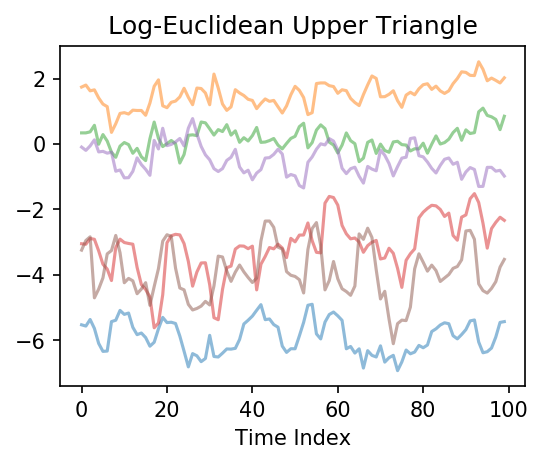

In [14]:
fig = plt.figure(figsize=(4, 3), dpi=150)
for j in range(6):
    plt.plot(Y[:, j], alpha=0.5)
plt.title('Log-Euclidean Upper Triangle')
plt.xlabel('Time Index')
plt.show()

In [15]:
from sklearn.decomposition import PCA

In [16]:
latent_dim = 2
pca = PCA(n_components=latent_dim)
components = pca.fit_transform(Y)

In [17]:
Y_hat = pca.inverse_transform(components)
mse = np.mean((Y - Y_hat) ** 2)
print(mse)

0.09555769765025585


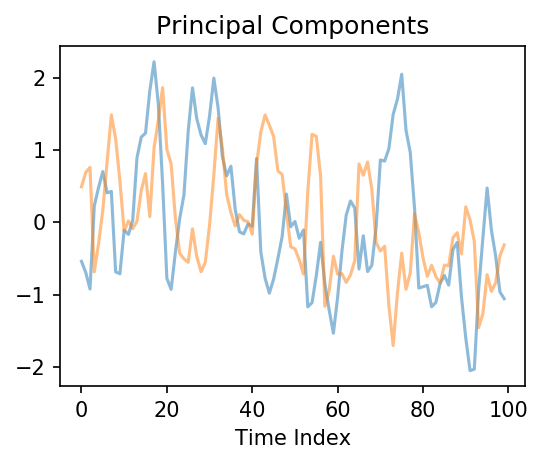

In [18]:
fig = plt.figure(figsize=(4, 3), dpi=150)
for j in range(2):
    plt.plot(components[:, j], alpha=0.5)
plt.title('Principal Components')
plt.xlabel('Time Index')
plt.show()

In [19]:
F = components

In [20]:
mu1, cov1 = sample_gp_posterior(F[:, 0])
mu2, cov2 = sample_gp_posterior(F[:, 1])

//anaconda/envs/tensorflow/lib/python2.7/site-packages/theano/tensor/basic.py:6611: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result[diagonal_slice] = x
Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [s, l]
Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [s, l]
The acceptance probability does not match the target. It is 0.9060979185086883, but should be close to 0.8. Try to increase the number of tuning steps.


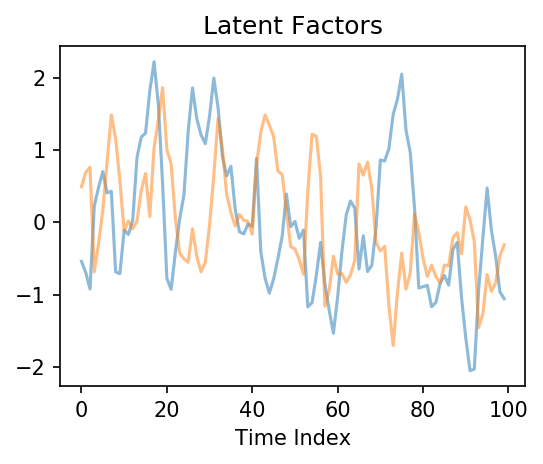

In [21]:
fig = plt.figure(figsize=(4, 3), dpi=150)
plt.plot(mu1, alpha=0.5)
plt.plot(mu2, alpha=0.5)
plt.title('Latent Factors')
plt.xlabel('Time Index')
plt.show()

In [22]:
print(cov1)

[[ 2.99998544e-06  2.00198746e-11 -1.26684219e-11 ...  1.19976519e-50
  -4.28752615e-51  1.08459391e-51]
 [ 2.00198746e-11  2.99995791e-06  3.74380527e-11 ... -4.74281113e-50
   1.69490887e-50 -4.28752568e-51]
 [-1.26684219e-11  3.74380527e-11  2.99994689e-06 ...  1.32716609e-49
  -4.74281081e-50  1.19976498e-50]
 ...
 [ 1.19976519e-50 -4.74281111e-50  1.32716609e-49 ...  2.99994689e-06
   3.74379416e-11 -1.26681998e-11]
 [-4.28752616e-51  1.69490887e-50 -4.74281080e-50 ...  3.74379416e-11
   2.99995791e-06  2.00197636e-11]
 [ 1.08459391e-51 -4.28752568e-51  1.19976498e-50 ... -1.26681998e-11
   2.00197636e-11  2.99998544e-06]]


In [23]:
print(Y.shape)
print(F.shape)

(100, 6)
(100, 2)


In [24]:
mu_0 = np.repeat(0, 2)
Sigma_0 = np.diag(np.repeat(1, 2))
a_0 = 1
b_0 = 1

In [25]:
loading_matrix, Y_variance = blr_mv(Y, F, mu_0, Sigma_0, a_0, b_0)

In [26]:
print(loading_matrix)
print(Y_variance)

[[ 0.04130418  0.09769719 -0.00639459 -0.70886857  0.07835626 -0.62262657]
 [ 0.78512456 -0.20014254 -0.08088833 -0.35617926  0.10273887 -0.49265763]]
[33.49955664  1.93294688  0.15695004  7.90998247  0.39822154 18.10202394]


In [27]:
S1, S2, S3, S4 = build_covariance_blocks([cov1, cov2], loading_matrix, Y_variance)

In [28]:
F_new = sample_conditional_F(Y, S1, S2, S3, S4)

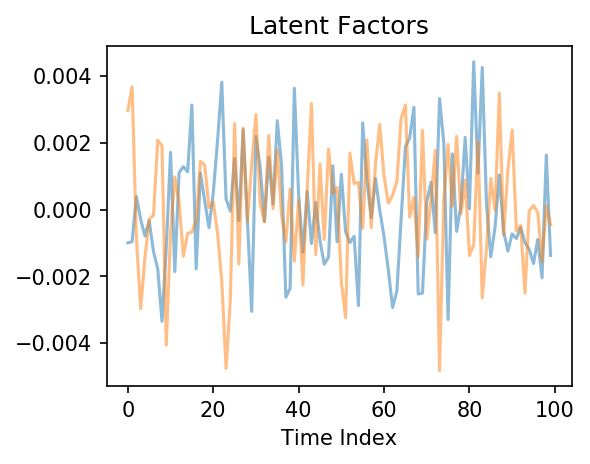

In [30]:
fig = plt.figure(figsize=(4, 3), dpi=150)
plt.plot(F_new[:, 0], alpha=0.5)
plt.plot(F_new[:, 1], alpha=0.5)
plt.title('Latent Factors')
plt.xlabel('Time Index')
plt.show()

In [31]:
mu_0 = np.repeat(0, 2)
Sigma_0 = np.diag(np.repeat(1, 2))
a_0 = 1
b_0 = 1

In [32]:
gp1_mu_sample = []
gp2_mu_sample = []
gp1_trace_sample = []
gp2_trace_sample = []
loading_sample = []
variance_sample = []
F_sample = []

In [33]:
F = components

In [34]:
from tqdm import tqdm as tqdm

In [35]:
for i in tqdm(range(10)):
    # sample from Gaussian process
    mu1, cov1, trace1 = sample_gp_posterior(F[:, 0], test=True)
    mu2, cov2, trace2 = sample_gp_posterior(F[:, 1], test=True)
    # Bayesian linear regression
    loading_matrix, Y_variance = blr_mv(Y, F, mu_0, Sigma_0, a_0, b_0)
    # sample from conditional distribution of F
    S1, S2, S3, S4 = build_covariance_blocks([cov1, cov2], loading_matrix, Y_variance)
    F = sample_conditional_F(Y, S1, S2, S3, S4)
    # collect sample
    gp1_mu_sample.append(mu1)
    gp2_mu_sample.append(mu2)
    gp1_trace_sample.append(trace1)
    gp2_trace_sample.append(trace2)
    loading_sample.append(loading_matrix)
    variance_sample.append(variance_sample)
    F_sample.append(F)

  0%|          | 0/10 [00:00<?, ?it/s]Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [s, l]
The acceptance probability does not match the target. It is 0.8926163510585396, but should be close to 0.8. Try to increase the number of tuning steps.
Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [s, l]
The acceptance probability does not match the target. It is 0.8937829133060717, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.906132114553968, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.
 10%|█         | 1/10 [00:29<04:26, 29.59s/it]Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing

KeyboardInterrupt: 